In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Read the matching results csv file
dfl = pd.read_csv('matching_detr_oap_r101_eos010_d.csv')
dfnl = pd.read_csv('matching_detr_oap_r101_eos005_nod.csv')
gt = pd.read_csv("gt_data.csv")

# rename the # basename column to basename
dfl.rename(columns={'# basename': 'basename'}, inplace=True)
dfnl.rename(columns={'# basename': 'basename'}, inplace=True)
gt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2080 entries, 0 to 2079
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   basename  2080 non-null   int64
 1   x_gt      2080 non-null   int64
 2   y_gt      2080 non-null   int64
dtypes: int64(3)
memory usage: 48.9 KB


# Let's visualize the distribution of keypoints in the dataset
<p>We can clearly identify that the task of detecting pole bases is in the context of highly structured images.</p>

<AxesSubplot:xlabel='x_gt', ylabel='y_gt'>

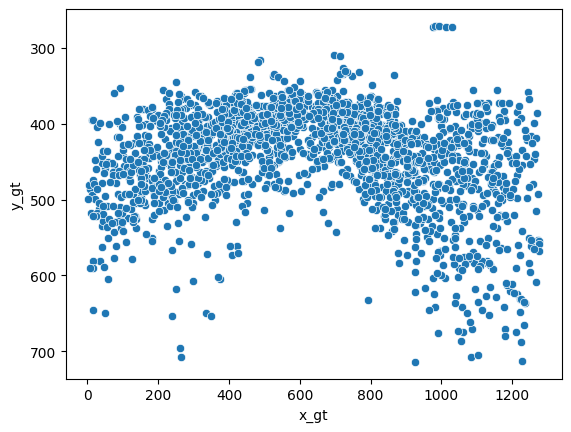

In [20]:
plt.gca().invert_yaxis()
sns.scatterplot(x='x_gt', y='y_gt', data=gt)


in_dfnl
True     1541
False     539
Name: count, dtype: int64


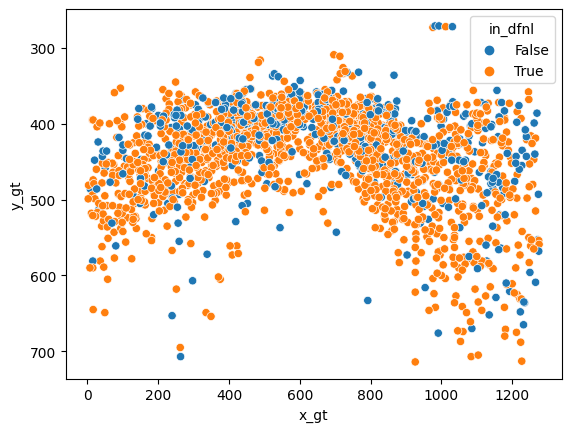

In [27]:
gt['in_dfnl'] = gt.apply(lambda row: True if (row['x_gt'], row['y_gt']) in zip(dfnl['x_gt'], dfnl['y_gt']) else False, axis=1)
gt['in_dfl'] = gt.apply(lambda row: True if (row['x_gt'], row['y_gt']) in zip(dfl['x_gt'], dfl['y_gt']) else False, axis=1)
plt.gca().invert_yaxis()

sns.scatterplot(x='x_gt', y='y_gt', data=gt, hue='in_dfnl')
print(gt['in_dfnl'].value_counts())


<AxesSubplot:xlabel='x_gt', ylabel='y_gt'>

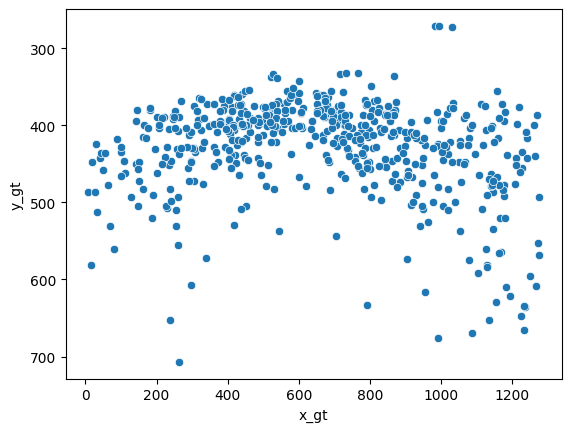

In [30]:
plt.gca().invert_yaxis()
sns.scatterplot(x='x_gt', y='y_gt', data=gt[gt.in_dfnl==False])


## Let's dig into the errors of the predictions

In [22]:
dfnl['l1_distance'] = dfnl.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
dfnl['x_distance'] = dfnl.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)
dfl['l1_distance'] = dfl.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
dfl['x_distance'] = dfl.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)

Average height for no Depth Loss model
Predicted: 444.99650959860384
Missed! 447.0073891625616
Average height for Depth Loss model
Predicted: 446.003738317757
Missed! 445.58290155440415


Text(0.5, 1.0, 'Depth Missed')

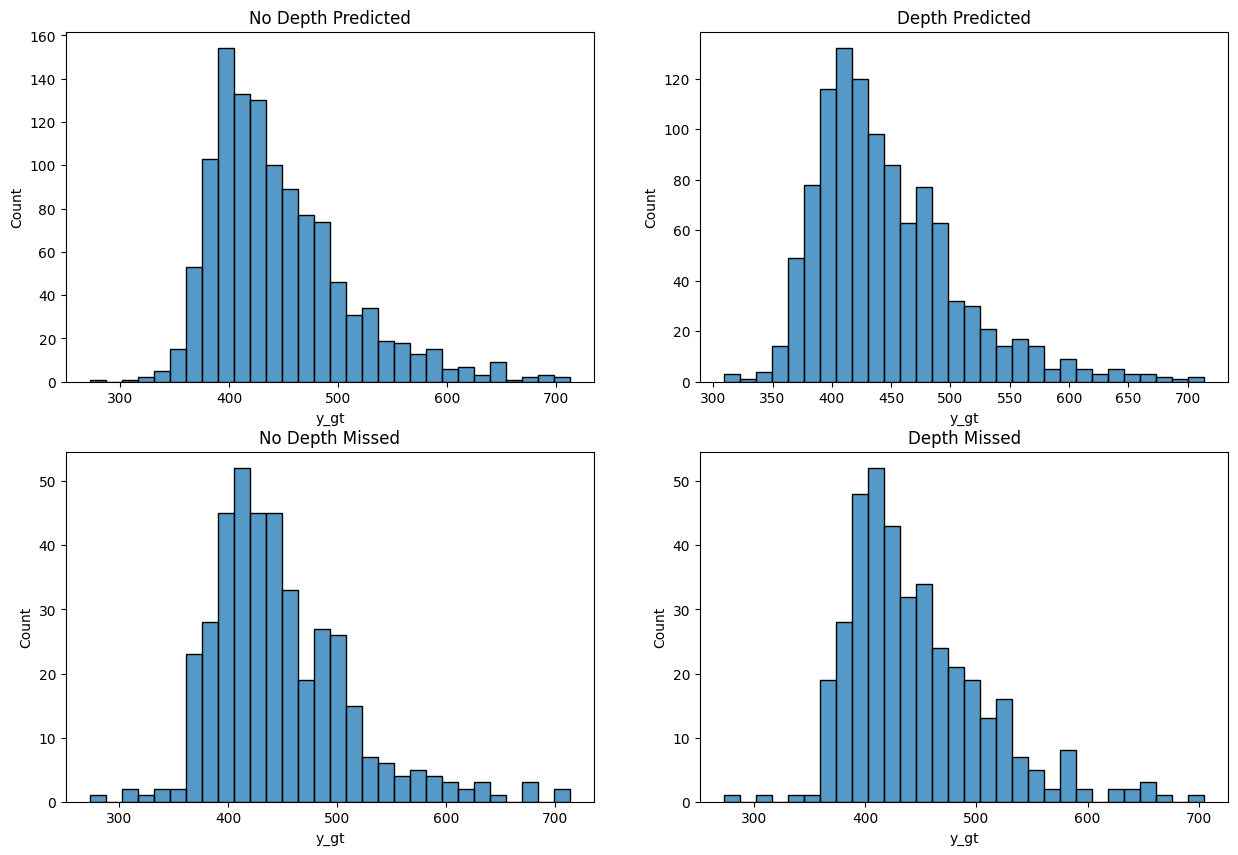

In [23]:
# compute the everage y_gt of df where in_dfnl is True and False
print("Average height for no Depth Loss model")
print(f"Predicted: {dfnl[gt['in_dfnl'] == True]['y_gt'].mean()}")
print(f"Missed! {dfnl[gt['in_dfnl'] == False]['y_gt'].mean()}")

print("Average height for Depth Loss model")
print(f"Predicted: {dfl[gt['in_dfnl'] == True]['y_gt'].mean()}")
print(f"Missed! {dfl[gt['in_dfnl'] == False]['y_gt'].mean()}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# show the distibution of y_gt of df where in_dfnl is True and False
sns.histplot(dfnl[gt['in_dfnl'] == True]['y_gt'], ax=axes[0,0], label='Predicted', bins=30)
sns.histplot(dfnl[gt['in_dfnl'] == False]['y_gt'], ax=axes[1,0], label='Missed', bins=30)
sns.histplot(dfl[gt['in_dfnl'] == True]['y_gt'], ax=axes[0,1], label='Predicted', bins=30)
sns.histplot(dfl[gt['in_dfnl'] == False]['y_gt'], ax=axes[1,1], label='Missed', bins=30)
axes[0,0].set_title('No Depth Predicted')
axes[1,0].set_title('No Depth Missed')
axes[0,1].set_title('Depth Predicted')
axes[1,1].set_title('Depth Missed')




Text(0, 0.5, 'density')

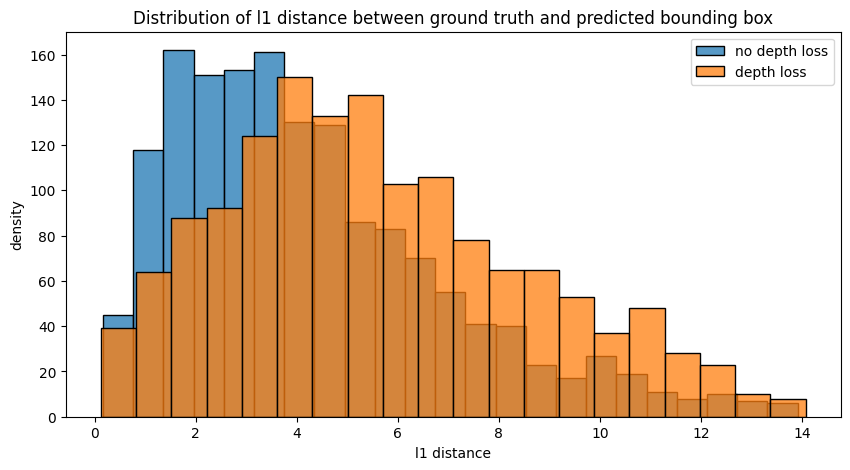

In [24]:
# plot the distribution of l1 distance using seaborn on the no depth loss model and the depth loss model
plt.figure(figsize=(10, 5))
sns.histplot(dfnl['l1_distance'], label='no depth loss')
sns.histplot(dfl['l1_distance'], label='depth loss')
plt.legend()
plt.title('Distribution of l1 distance between ground truth and predicted bounding box')
plt.xlabel('l1 distance')
plt.ylabel('density')

(0.0, 10.0)

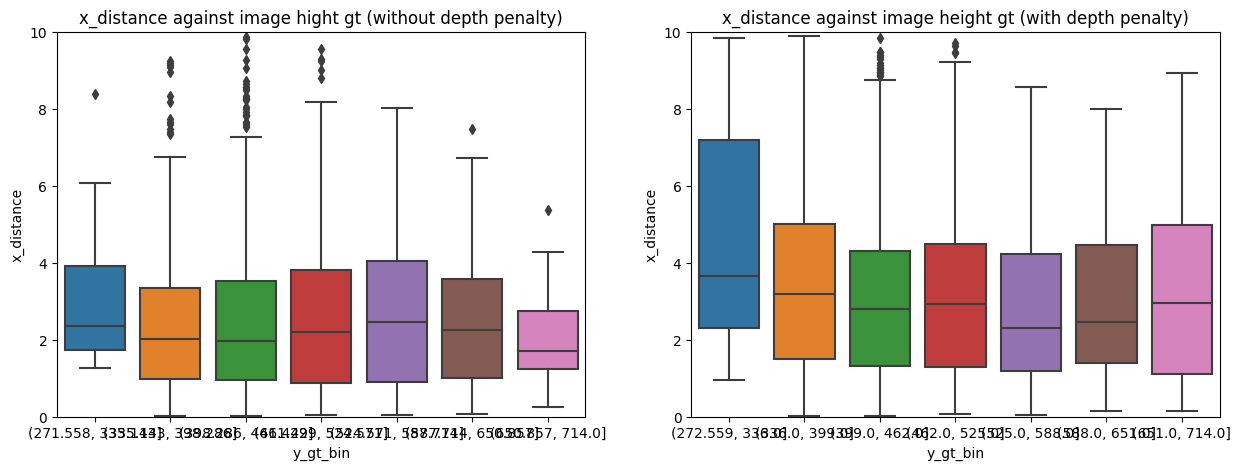

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


dfl['y_gt_bin'] = pd.cut(dfl['y_gt'], bins=7)
dfnl['y_gt_bin'] = pd.cut(dfnl['y_gt'], bins=7)

sns.boxplot(x='y_gt_bin', y='x_distance', data=dfnl, ax = ax1)
sns.boxplot(x='y_gt_bin', y='x_distance', data=dfl, ax = ax2)
ax1.set_title('x_distance against image hight gt (without depth penalty)')
ax2.set_title('x_distance against image height gt (with depth penalty)')
ax1.set_ylim(0,10)
ax2.set_ylim(0,10)

<AxesSubplot:xlabel='y_gt', ylabel='x_distance'>

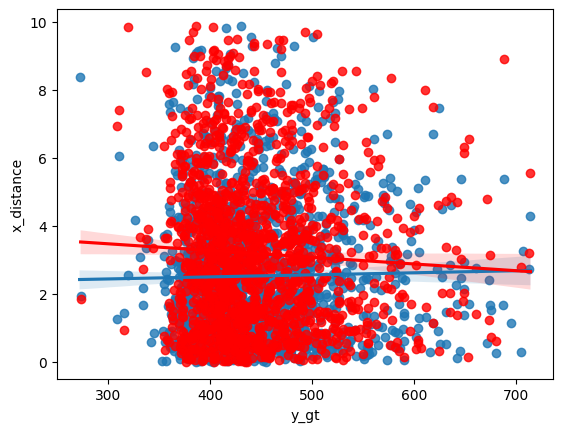

In [49]:
order = 1
sns.regplot(x='y_gt', y='x_distance', data=dfnl, order=order)

# regplot with blue points and red line
sns.regplot(x='y_gt', y='x_distance', data=dfl, order=order, color='red')

### Conclusion

- It does not seem that adding a depth penalty to the loss helps the network predict better (as shown in the above regplot).
- The model seems to predict more accurate results without a depth penalty (as shown in the above regplot).
- Trying to find geospatial differences between predicted and unpredicted images did not yield any results.

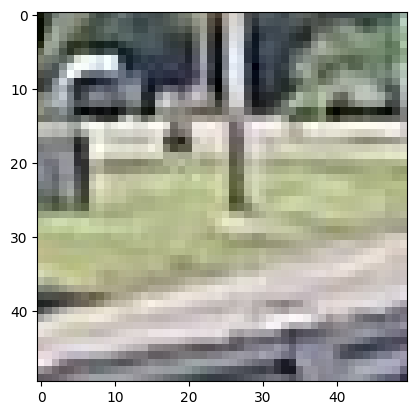

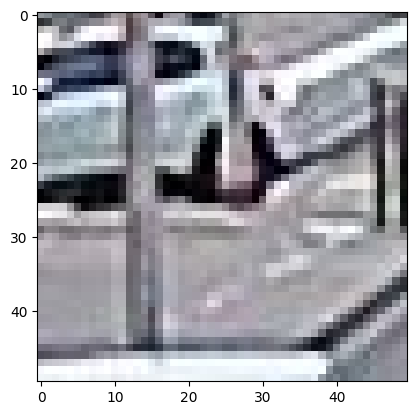

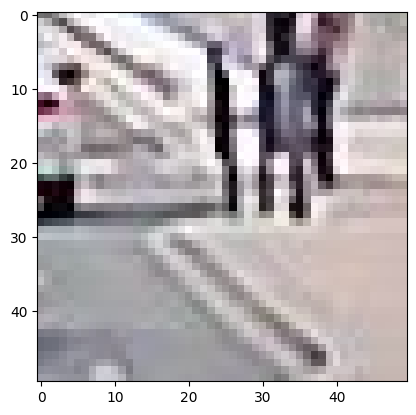

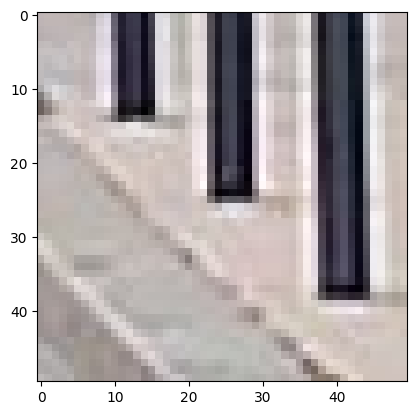

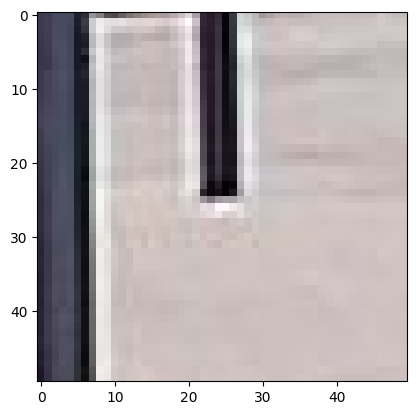

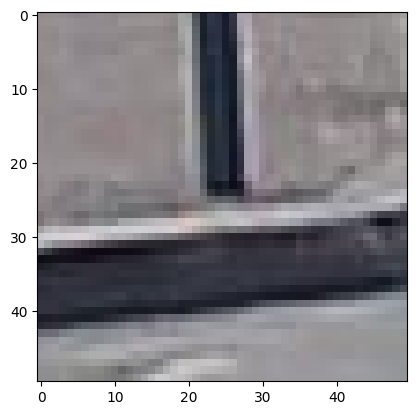

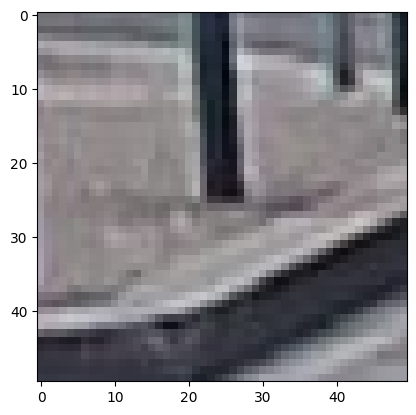

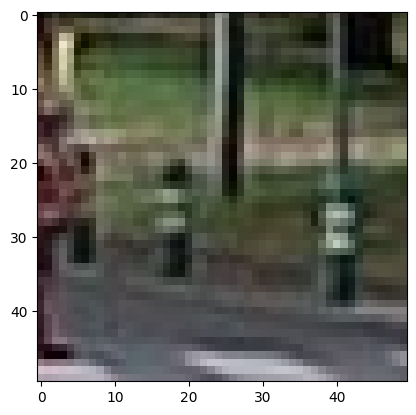

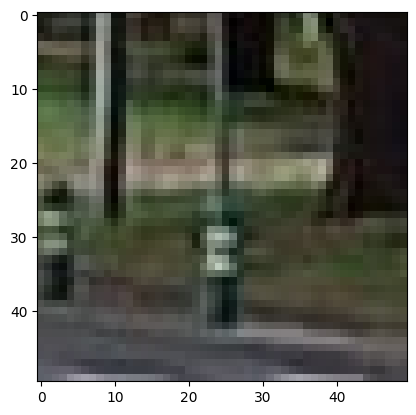

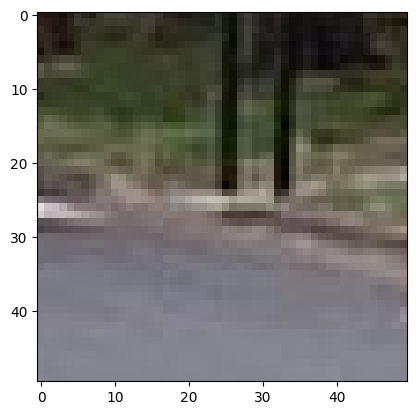

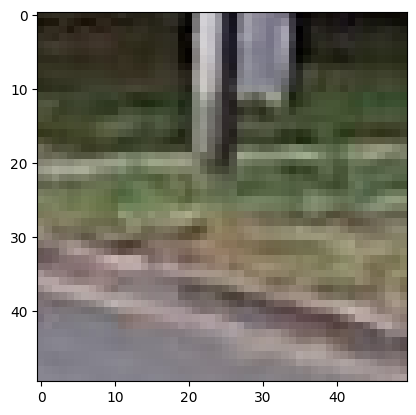

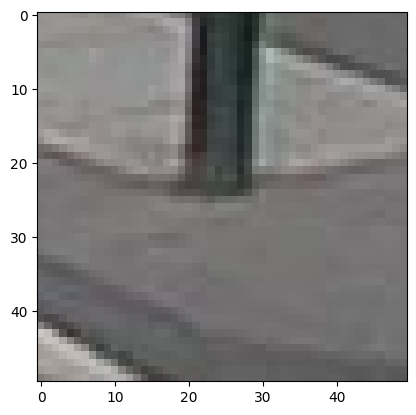

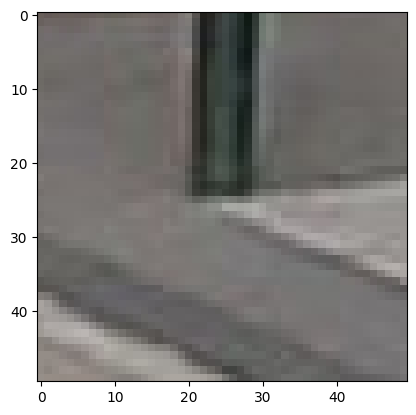

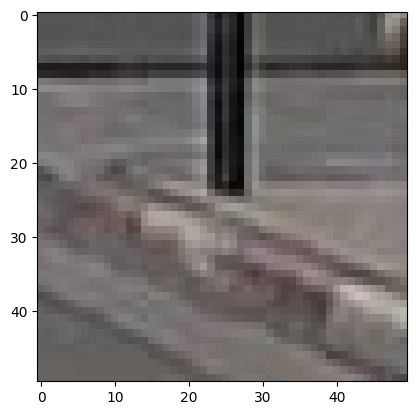

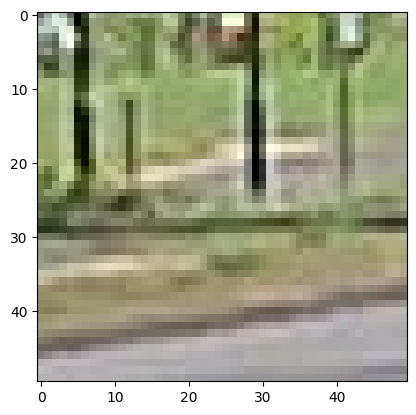

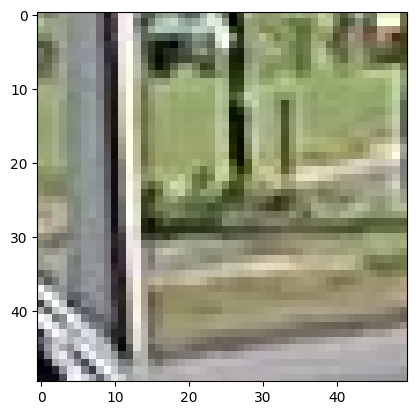

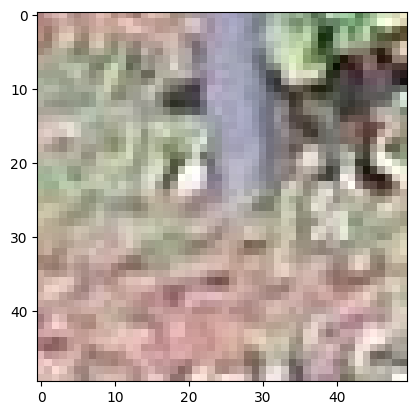

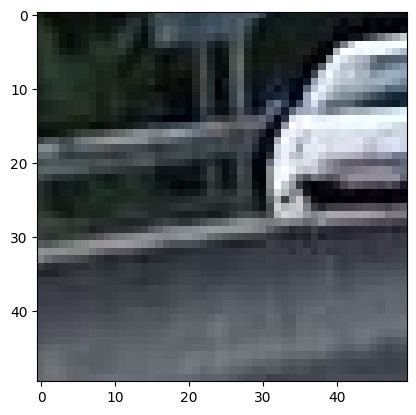

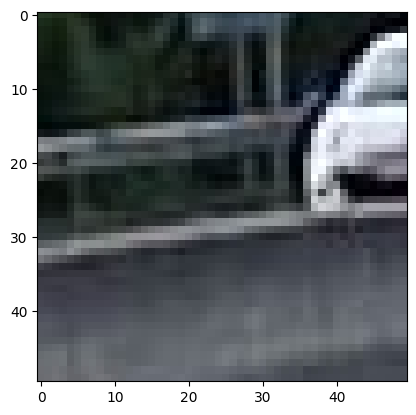

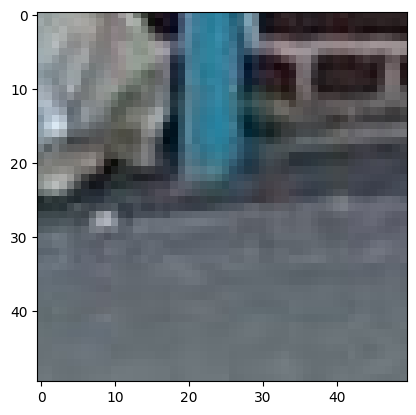

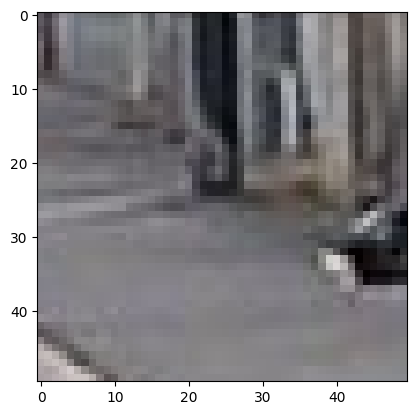

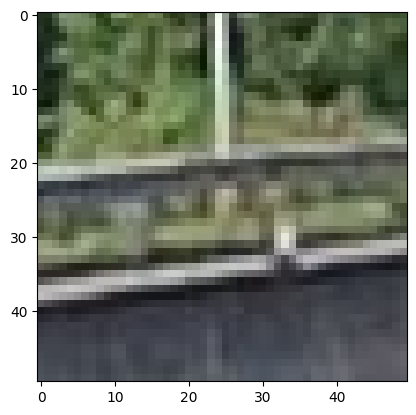

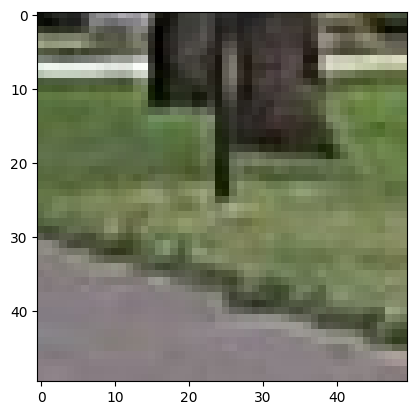

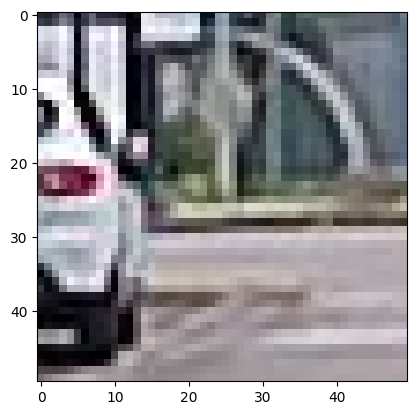

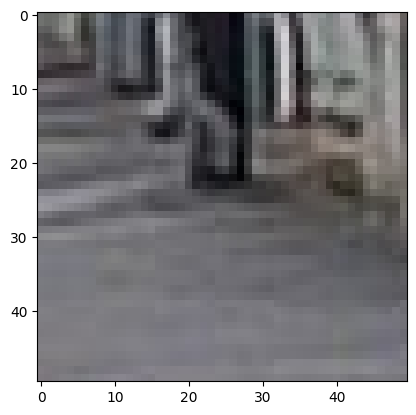

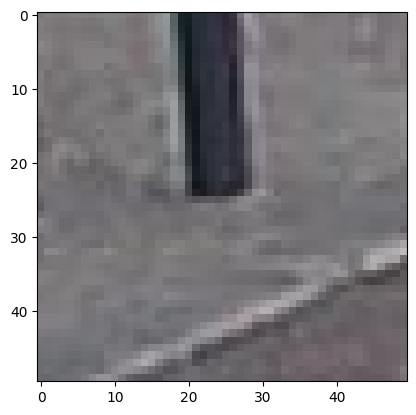

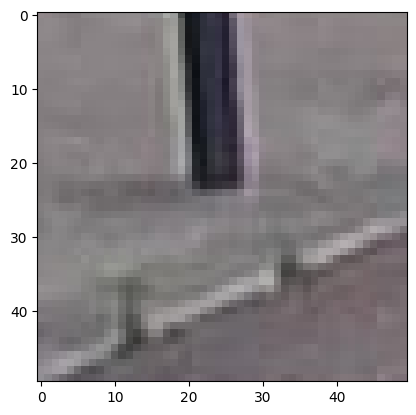

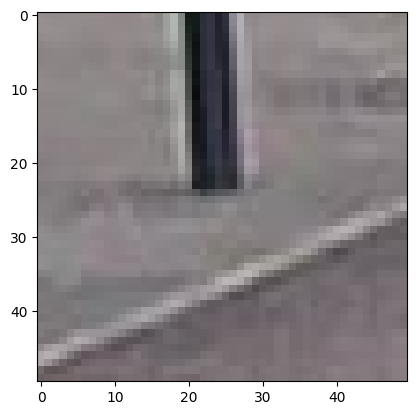

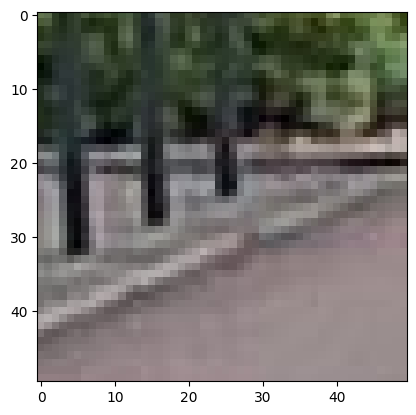

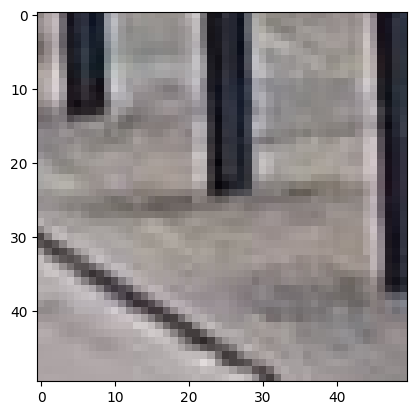

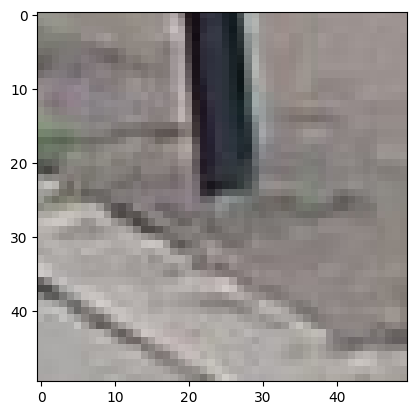

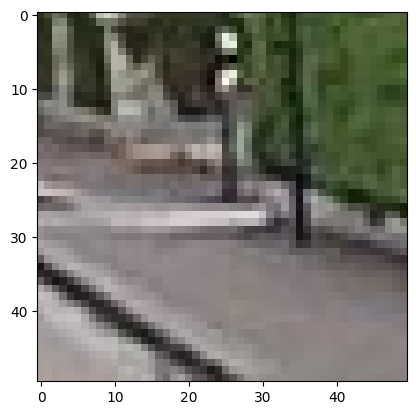

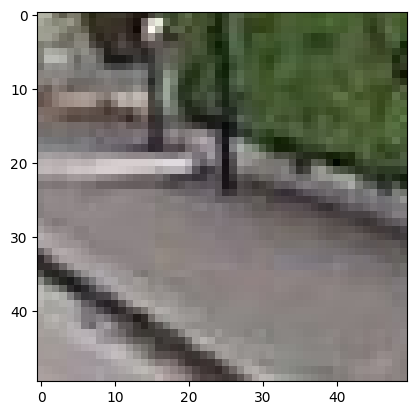

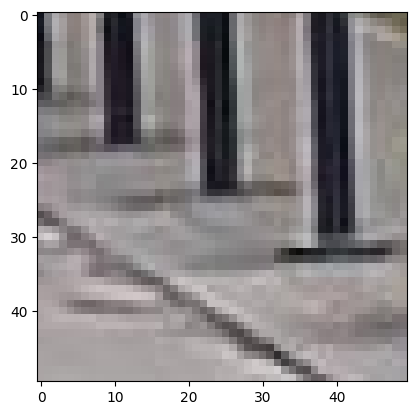

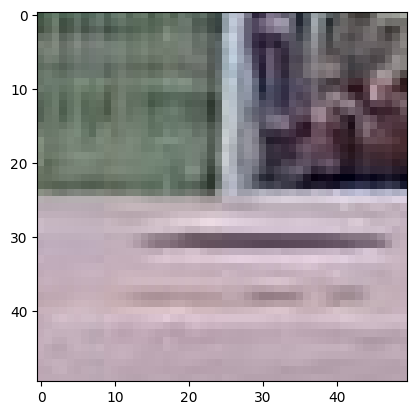

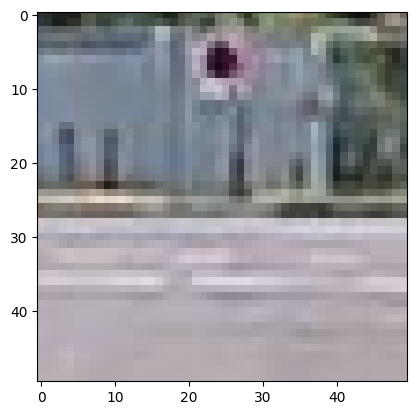

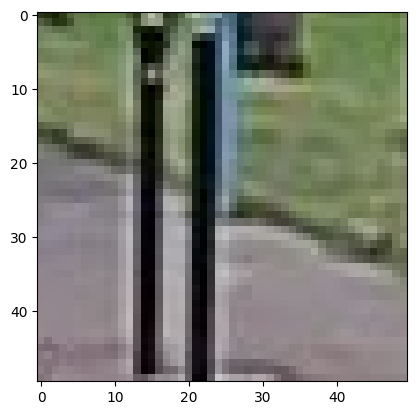

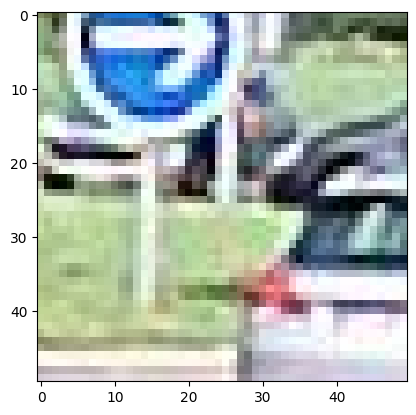

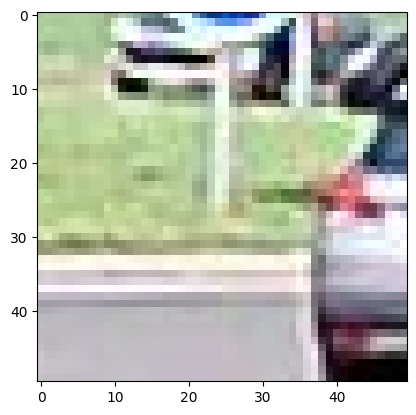

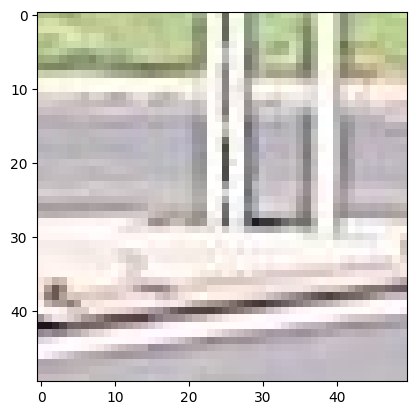

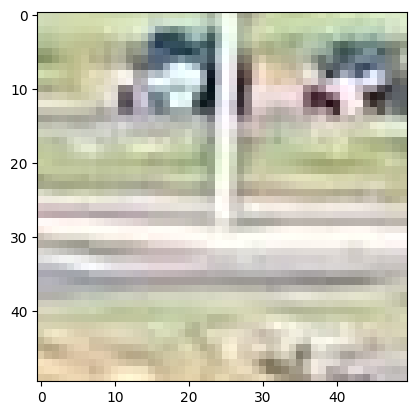

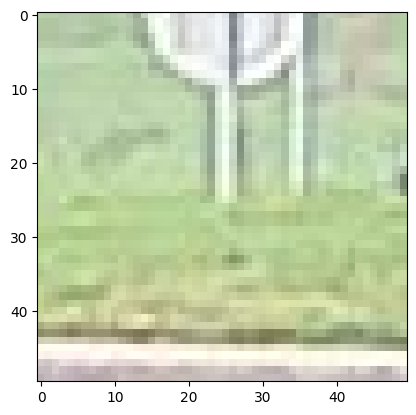

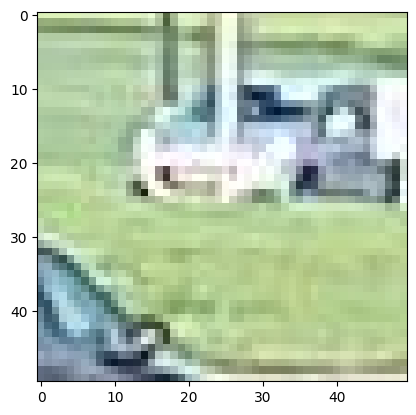

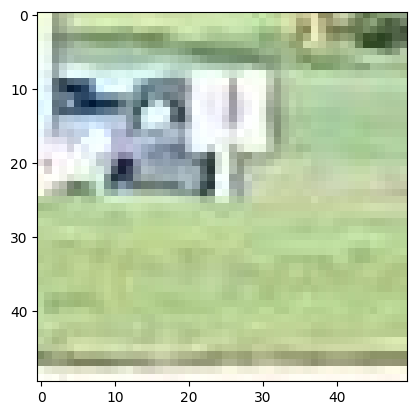

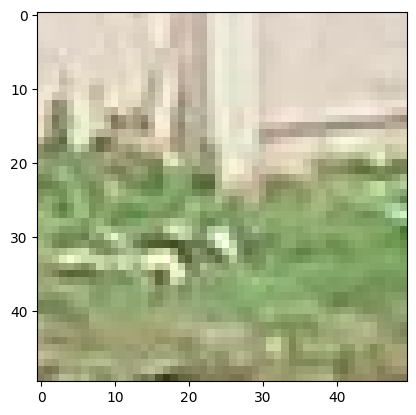

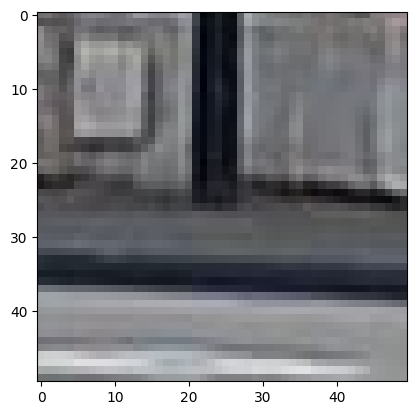

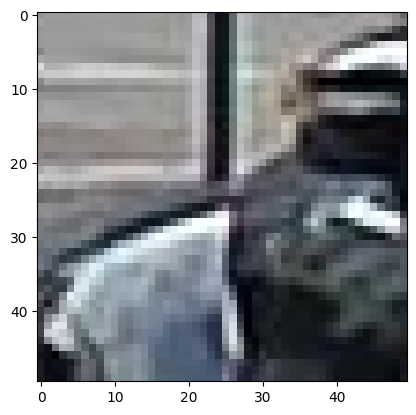

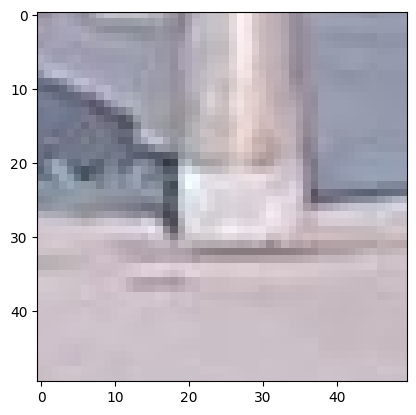

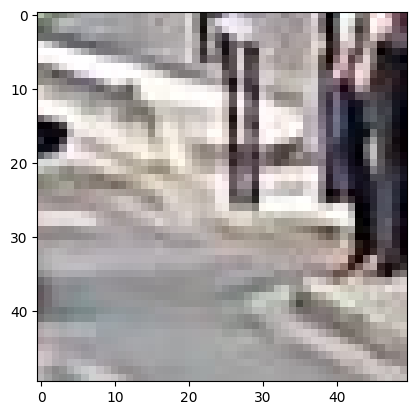

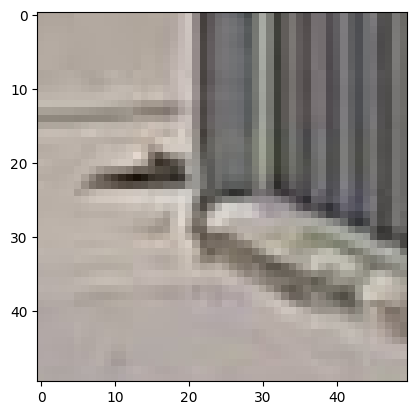

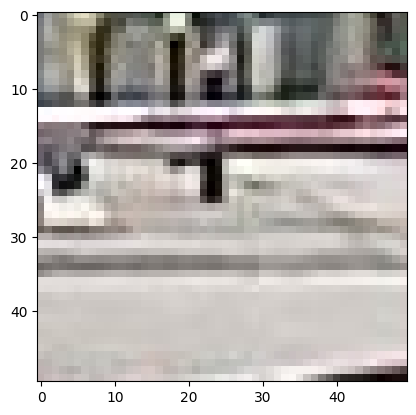

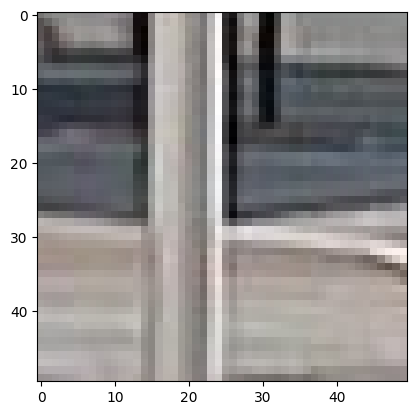

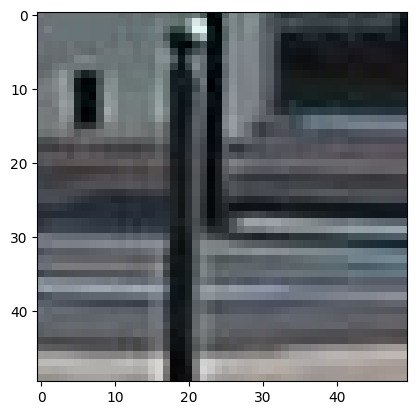

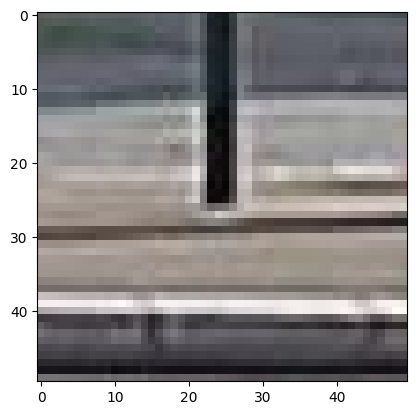

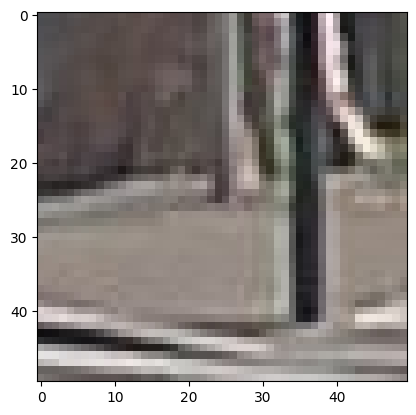

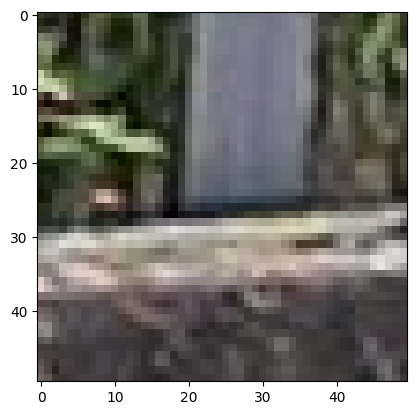

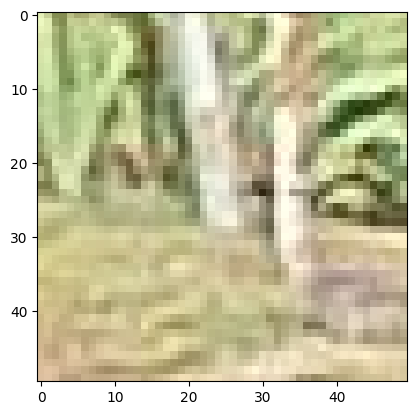

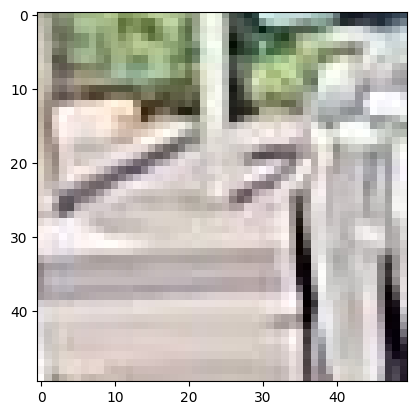

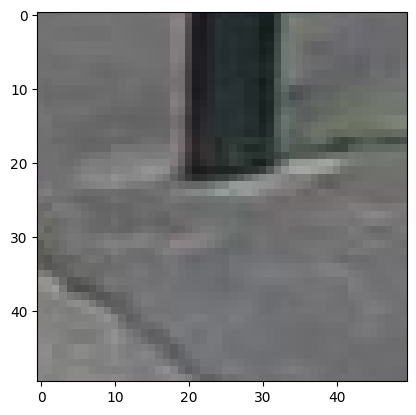

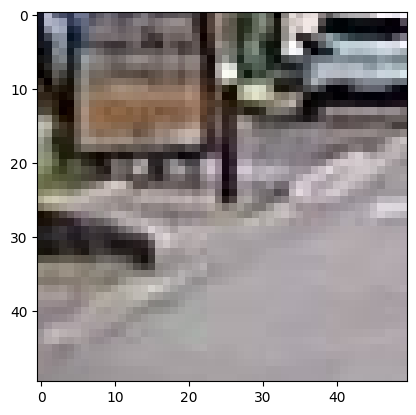

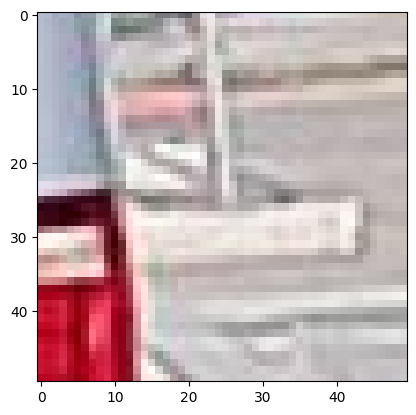

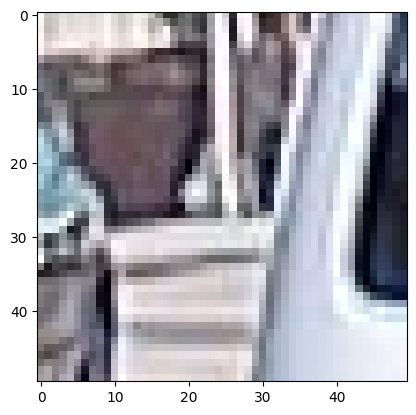

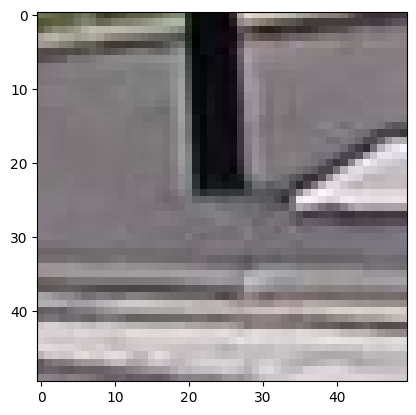

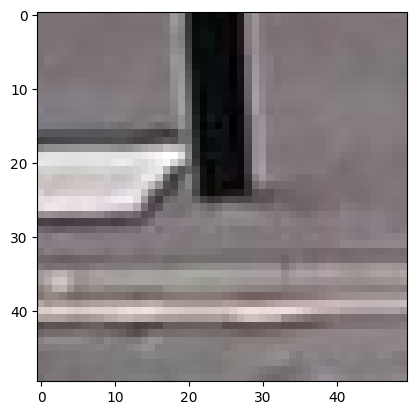

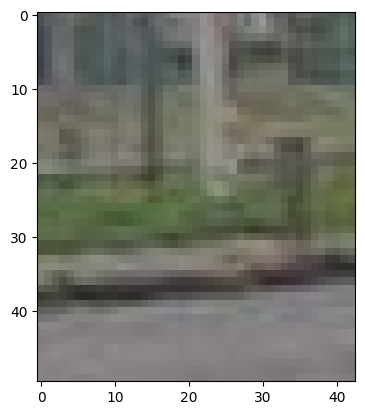

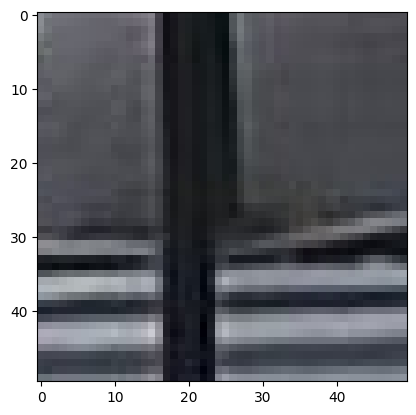

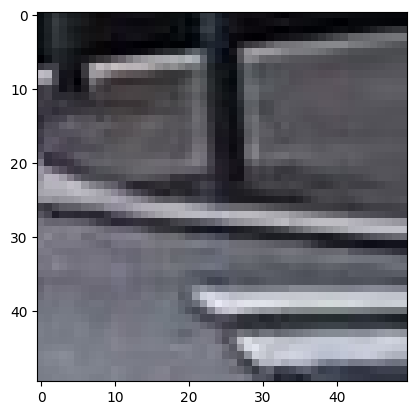

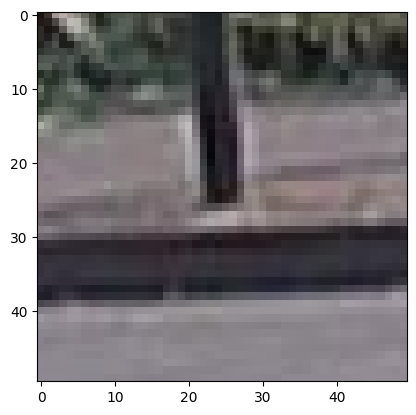

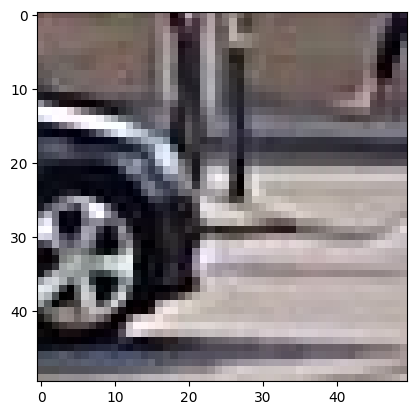

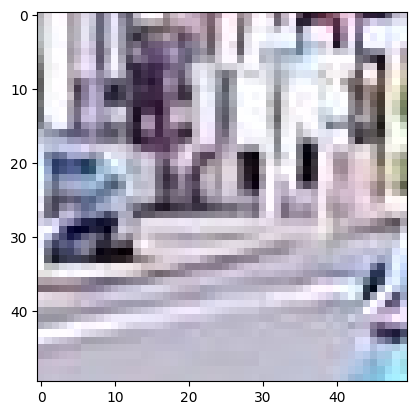

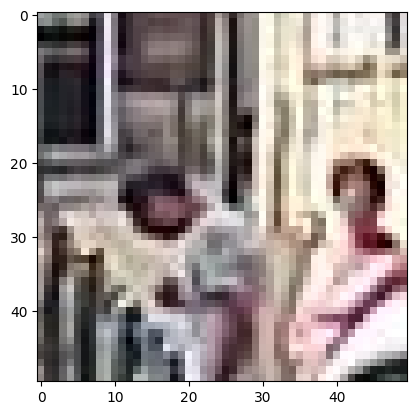

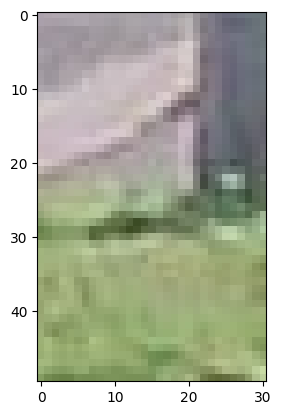

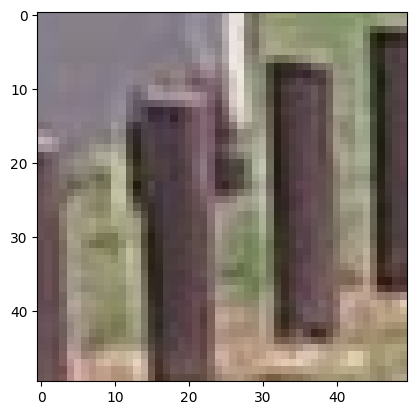

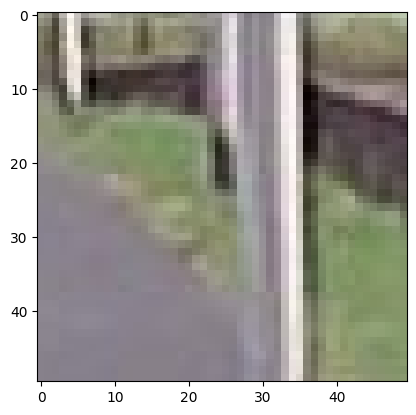

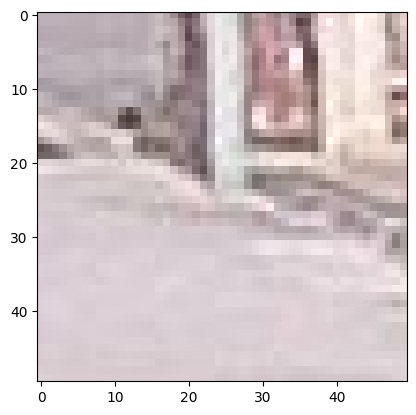

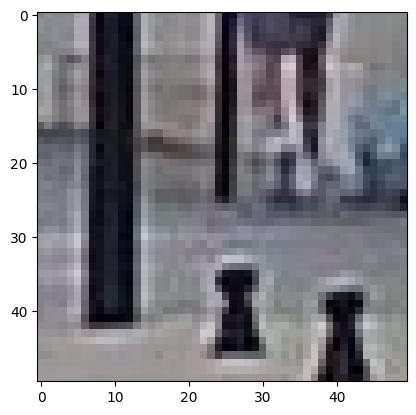

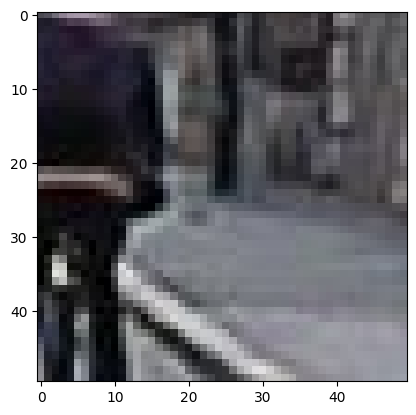

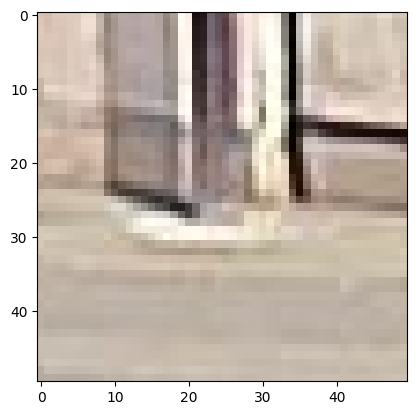

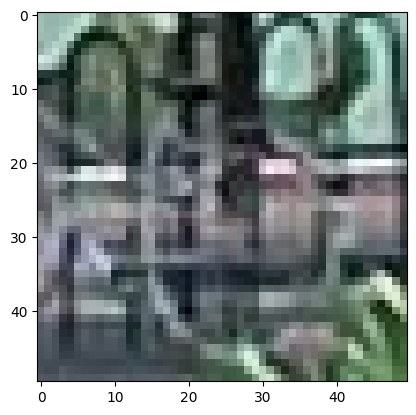

In [61]:
""" 
store the basename and  of each (x_gt, y_gt) where in_dfnl is False (missed)
"""
missed = gt[gt.in_dfnl==False]

# for each missed element, open the image, extract a region around the (x_gt, y_gt) of 50x50 and display it
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for index, row in missed.iterrows():
    img_path = "../data_manual_annotations/images/val/" + str(row['basename']) + ".jpg"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[row['y_gt']-25:row['y_gt']+25, row['x_gt']-25:row['x_gt']+25]
        plt.imshow(img)
        plt.show()
        plt.close()